# PRO GAN

In [1]:
# !pip install -q kaggle
# !mkdir ~/.kaggle
# !cp /teamspace/uploads/kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets download xhlulu/140k-real-and-fake-faces

# import shutil
# shutil.unpack_archive('140k-real-and-fake-faces.zip')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
from tqdm import tqdm
from math import log2
from scipy.stats import truncnorm
import random
import numpy as np
import os
import datetime
from PIL import Image
torch.manual_seed(69)

## Config

In [3]:
os.makedirs("models", exist_ok=True)
class Config:
    START_TRAIN_AT_IMG_SIZE = 4
    DATASET = 'real_vs_fake/real-vs-fake/train'
    CHECKPOINT_GEN = "models/pro_generator_128_2.pth"
    CHECKPOINT_CRITIC = "models/pro_critic_128_2.pth"
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    SAVE_MODEL = True
    LOAD_MODEL = False
    LEARNING_RATE = 1e-3
    BATCH_SIZES = [512, 512, 512, 256, 256, 128]
    FACTORS = [1, 1/2, 1/4, 1/6, 1/8, 1/16]
    CHANNELS_IMG = 3
    Z_DIM = 256
    IN_CHANNELS = 512
    LAMBDA_GP = 10
    PROGRESSIVE_EPOCHS = [30] * len(BATCH_SIZES)
    FIXED_NOISE = torch.randn(8, Z_DIM, 1, 1).to(DEVICE)
    NUM_WORKERS = 32
    TRAIN_SUBSET_SIZE = 25000

config = Config()

## Model

In [4]:
class WSConv2d(nn.Module):
    """
    Weight scaled Conv2d (Equalized Learning Rate)
    Note that input is multiplied rather than changing weights
    this will have the same result.

    Inspired and looked at:
    https://github.com/nvnbny/progressive_growing_of_gans/blob/master/modelUtils.py
    """

    def __init__(
        self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, gain=2
    ):
        super(WSConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.scale = (gain / (in_channels * (kernel_size ** 2))) ** 0.5
        self.bias = self.conv.bias
        self.conv.bias = None

        # initialize conv layer
        nn.init.normal_(self.conv.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        return self.conv(x * self.scale) + self.bias.view(1, self.bias.shape[0], 1, 1)


class PixelNorm(nn.Module):
    def __init__(self):
        super(PixelNorm, self).__init__()
        self.epsilon = 1e-8

    def forward(self, x):
        return x / torch.sqrt(torch.mean(x ** 2, dim=1, keepdim=True) + self.epsilon)


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_pixelnorm=True):
        super(ConvBlock, self).__init__()
        self.use_pn = use_pixelnorm
        self.conv1 = WSConv2d(in_channels, out_channels)
        self.conv2 = WSConv2d(out_channels, out_channels)
        self.leaky = nn.LeakyReLU(0.2)
        self.pn = PixelNorm()

    def forward(self, x):
        x = self.leaky(self.conv1(x))
        x = self.pn(x) if self.use_pn else x
        x = self.leaky(self.conv2(x))
        x = self.pn(x) if self.use_pn else x
        return x


class Generator(nn.Module):
    def __init__(self, z_dim, in_channels, img_channels=3):
        super(Generator, self).__init__()

        # initial takes 1x1 -> 4x4
        self.initial = nn.Sequential(
            PixelNorm(),
            nn.ConvTranspose2d(z_dim, in_channels, 4, 1, 0),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            PixelNorm(),
        )

        # Converts n channel image to rgb channel
        self.initial_vec_to_rgb = WSConv2d(
            in_channels, img_channels, kernel_size=1, stride=1, padding=0
        )

        self.prog_blocks, self.vec_to_rgb_layers = (
            nn.ModuleList([]),
            nn.ModuleList([self.initial_vec_to_rgb]),
        )

        for i in range(
            len(config.FACTORS) - 1
        ):  # -1 to prevent index error because of factors[i+1]
            conv_in_c = int(in_channels * config.FACTORS[i])
            conv_out_c = int(in_channels * config.FACTORS[i + 1])
            self.prog_blocks.append(ConvBlock(conv_in_c, conv_out_c))
            self.vec_to_rgb_layers.append(
                WSConv2d(conv_out_c, img_channels, kernel_size=1, stride=1, padding=0)
            )

    def fade_in(self, alpha, upscaled, generated):
        # alpha should be scalar within [0, 1], and upscale.shape == generated.shape
        return alpha * generated + (1 - alpha) * upscaled

    def forward(self, x, alpha, steps):
        out = self.initial(x) # 1x1 to 4x4

        if steps == 0:
            return self.initial_vec_to_rgb(out)

        for step in range(steps):
            upscaled = F.interpolate(out, scale_factor=2, mode="nearest")
            out = self.prog_blocks[step](upscaled)

        # The number of channels in upscale will stay the same, while
        # out which has moved through prog_blocks might change. To ensure
        # we can convert both to rgb we use different vec_to_rgb_layers
        # (steps-1) and steps for upscaled, out respectively
        final_upscaled = self.vec_to_rgb_layers[steps - 1](upscaled)
        final_out = self.vec_to_rgb_layers[steps](out)
        return torch.tanh(self.fade_in(alpha, final_upscaled, final_out))

In [5]:
class Discriminator(nn.Module):
    def __init__(self, z_dim, in_channels, img_channels=3):
        super(Discriminator, self).__init__()
        self.prog_blocks, self.rgb_to_vec_layers = nn.ModuleList([]), nn.ModuleList([])
        self.leaky = nn.LeakyReLU(0.2)

        # here we work back ways from factors because the discriminator
        # should be mirrored from the generator. So the first prog_block and
        # rgb_to_vec layer we append will work for input size 1024x1024, then 512->256-> etc
        for i in range(len(config.FACTORS) - 1, 0, -1):
            conv_in = int(in_channels * config.FACTORS[i])
            conv_out = int(in_channels * config.FACTORS[i - 1])
            self.prog_blocks.append(ConvBlock(conv_in, conv_out, use_pixelnorm=False))
            self.rgb_to_vec_layers.append(
                WSConv2d(img_channels, conv_in, kernel_size=1, stride=1, padding=0)
            )

        # perhaps confusing name "initial_rgb_to_vec" this is just the RGBto_vec layer for 4x4 input size
        # did this to "mirror" the generator initial_rgb_to_vec
        self.initial_rgb_to_vec = WSConv2d(
            img_channels, in_channels, kernel_size=1, stride=1, padding=0
        )
        self.rgb_to_vec_layers.append(self.initial_rgb_to_vec)
        self.avg_pool = nn.AvgPool2d(
            kernel_size=2, stride=2
        )  # down sampling using avg pool

        # this is the block for 4x4 input size
        self.final_block = nn.Sequential(
            # +1 to in_channels because we concatenate from MiniBatch std
            WSConv2d(in_channels + 1, in_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, in_channels, kernel_size=4, padding=0, stride=1),
            nn.LeakyReLU(0.2),
            WSConv2d(
                in_channels, 1, kernel_size=1, padding=0, stride=1
            ),  # we use this instead of linear layer
        )

    def fade_in(self, alpha, downscaled, out):
        """Used to fade in downscaled using avg pooling and output from CNN"""
        # alpha should be scalar within [0, 1], and upscale.shape == generated.shape
        return alpha * out + (1 - alpha) * downscaled

    def minibatch_std(self, x):
        batch_statistics = (
            torch.std(x, dim=0).mean().repeat(x.shape[0], 1, x.shape[2], x.shape[3])
        )
        # we take the std for each example (across all channels, and pixels) then we repeat it
        # for a single channel and concatenate it with the image. In this way the discriminator
        # will get information about the variation in the batch/image
        return torch.cat([x, batch_statistics], dim=1)

    def forward(self, x, alpha, steps):
        # where we should start in the list of prog_blocks, maybe a bit confusing but
        # the last is for the 4x4. So example let's say steps=1, then we should start
        # at the second to last because input_size will be 8x8. If steps==0 we just
        # use the final block
        cur_step = len(self.prog_blocks) - steps

        # convert from rgb_to_vec as initial step, this will depend on
        # the image size (each will have it's on rgb_to_vec layer)
        out = self.leaky(self.rgb_to_vec_layers[cur_step](x))

        if steps != 0:# i.e, image is anything other than 4x4
            # because prog_blocks might change the channels, for down scale we use rgb_to_vec_layer
            # from previous/smaller size which in our case correlates to +1 in the indexing
            downscaled = self.leaky(self.rgb_to_vec_layers[cur_step + 1](self.avg_pool(x)))
            out = self.avg_pool(self.prog_blocks[cur_step](out))

            # the fade_in is done first between the downscaled and the input
            # this is opposite from the generator
            out = self.fade_in(alpha, downscaled, out)

            for step in range(cur_step + 1, len(self.prog_blocks)):
                out = self.prog_blocks[step](out)
                out = self.avg_pool(out)

        out = self.minibatch_std(out)
        return self.final_block(out).view(out.shape[0], -1)

In [6]:
gen = Generator(config.Z_DIM, config.IN_CHANNELS, img_channels=3)
critic = Discriminator(config.Z_DIM, config.IN_CHANNELS, img_channels=3)

for img_size in [4, 8, 16, 32, 64, 128]:
    num_steps = int(log2(img_size / 4))
    x = torch.randn((1, config.Z_DIM, 1, 1))
    z = gen(x, 0.5, steps=num_steps)
    assert z.shape == (1, 3, img_size, img_size)
    out = critic(z, alpha=0.5, steps=num_steps)
    assert out.shape == (1, 1)
    print(f"Success! At img size: {img_size}")

Success! At img size: 4
Success! At img size: 8
Success! At img size: 16
Success! At img size: 32
Success! At img size: 64
Success! At img size: 128


/tmp/ipykernel_8282/1651960601.py:47: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  torch.std(x, dim=0).mean().repeat(x.shape[0], 1, x.shape[2], x.shape[3])


## Utils

In [7]:
# Print losses occasionally and print to tensorboard
def plot_to_tensorboard(
    writer, loss_critic, loss_gen, real, fake, tensorboard_step
):
    writer.add_scalar("Loss/Critic", loss_critic, global_step=tensorboard_step, new_style=True)
    writer.add_scalar("Loss/Gen", loss_gen, global_step=tensorboard_step, new_style=True)

    with torch.no_grad():
        # take out (up to) 8 examples to plot
        # img_grid_real = torchvision.utils.make_grid(real[:8], normalize=True)
        img_grid_fake = torchvision.utils.make_grid(fake[:8], normalize=True)
        # writer.add_image("Real", img_grid_real, global_step=tensorboard_step)
        writer.add_image("Fake", img_grid_fake, global_step=tensorboard_step)


def gradient_penalty(critic, real, fake, alpha, train_step, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    beta = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * beta + fake.detach() * (1 - beta)
    interpolated_images.requires_grad_(True)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images, alpha, train_step)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty


def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location="cuda")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

## Training

In [8]:
log_folder_name = f"logs/{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}/"
os.makedirs(log_folder_name, exist_ok=True)

In [9]:
torch.backends.cudnn.benchmarks = True


def get_loader(image_size):
    transform = transforms.Compose(
        [
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.Normalize(
                [0.5 for _ in range(config.CHANNELS_IMG)],
                [0.5 for _ in range(config.CHANNELS_IMG)],
            ),
        ]
    )
    batch_size = config.BATCH_SIZES[int(log2(image_size / 4))]
    dataset = datasets.ImageFolder(root=config.DATASET, transform=transform)
    class_idx = dataset.class_to_idx["real"]
    class_indices = [i for i, label in enumerate(dataset.targets) if label == class_idx]
    subset_indices = class_indices[:config.TRAIN_SUBSET_SIZE]
    subset_dataset = Subset(dataset, subset_indices)
    loader = DataLoader(
        subset_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=config.NUM_WORKERS,
        pin_memory=True,
        drop_last=True
    )
    return loader, dataset


def train_fn(
    critic,
    gen,
    loader,
    dataset,
    step,
    alpha,
    opt_critic,
    opt_gen,
    tensorboard_step,
    writer,
    scaler_gen,
    scaler_critic,
    log_folder_name,
):
    loop = tqdm(loader, leave=True)
    for batch_idx, (real, _) in enumerate(loop):
        real = real.to(config.DEVICE)
        cur_batch_size = real.shape[0]

        # Train Critic: max E[critic(real)] - E[critic(fake)] <-> min -E[critic(real)] + E[critic(fake)]
        # which is equivalent to minimizing the negative of the expression
        noise = torch.randn(cur_batch_size, config.Z_DIM, 1, 1).to(config.DEVICE)

        with torch.cuda.amp.autocast():
            fake = gen(noise, alpha, step)
            critic_real = critic(real, alpha, step)
            critic_fake = critic(fake.detach(), alpha, step)
            gp = gradient_penalty(critic, real, fake, alpha, step, device=config.DEVICE)
            loss_critic = (
                -(torch.mean(critic_real) 
                - torch.mean(critic_fake))
                + config.LAMBDA_GP * gp
                + (0.001 * torch.mean(critic_real ** 2))
            )

        opt_critic.zero_grad()
        scaler_critic.scale(loss_critic).backward()
        scaler_critic.step(opt_critic)
        scaler_critic.update()

        # Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
        with torch.cuda.amp.autocast():
            gen_fake = critic(fake, alpha, step)
            loss_gen = -torch.mean(gen_fake)

        opt_gen.zero_grad()
        scaler_gen.scale(loss_gen).backward()
        scaler_gen.step(opt_gen)
        scaler_gen.update()

        # Update alpha and ensure less than 1
        alpha += cur_batch_size / (
            (config.PROGRESSIVE_EPOCHS[step] * 0.5) * len(dataset)
        )
        alpha = min(alpha, 1)

        loop.set_postfix(
            gp=gp.item(),
            loss_critic=loss_critic.item(),
            loss_gen=loss_gen.item()
        )
    
    with torch.no_grad():
        fixed_fakes = gen(config.FIXED_NOISE, alpha, step) * 0.5 + 0.5
    plot_to_tensorboard(
        writer,
        loss_critic.item(),
        loss_gen.item(),
        real.detach(),
        fixed_fakes.detach(),
        tensorboard_step,
    )
    tensorboard_step += 1
    
    # os.makedirs(log_folder_name + "training", exist_ok=True)
    # save_image(fixed_fakes, log_folder_name + f"training/{step}_{epoch}.png", normalize=True)

    return tensorboard_step, alpha



# initialize gen and disc, note: discriminator should be called critic,
# according to WGAN paper (since it no longer outputs between [0, 1])
# but really who cares..
gen = Generator(
    config.Z_DIM, config.IN_CHANNELS, img_channels=config.CHANNELS_IMG
).to(config.DEVICE)
critic = Discriminator(
    config.Z_DIM, config.IN_CHANNELS, img_channels=config.CHANNELS_IMG
).to(config.DEVICE)

# initialize optimizers and scalers for FP16 training
opt_gen = optim.Adam(gen.parameters(), lr=config.LEARNING_RATE, betas=(0.0, 0.99))
opt_critic = optim.Adam(
    critic.parameters(), lr=config.LEARNING_RATE, betas=(0.0, 0.99)
)
scaler_critic = torch.cuda.amp.GradScaler()
scaler_gen = torch.cuda.amp.GradScaler()

# for tensorboard plotting
writer = SummaryWriter(log_folder_name)

if config.LOAD_MODEL:
    load_checkpoint(
        config.CHECKPOINT_GEN, gen, opt_gen, config.LEARNING_RATE,
    )
    load_checkpoint(
        config.CHECKPOINT_CRITIC, critic, opt_critic, config.LEARNING_RATE,
    )

gen.train()
critic.train()

tensorboard_step = 0
# start at step that corresponds to img size that we set in config
step = int(log2(config.START_TRAIN_AT_IMG_SIZE / 4))
for num_epochs in config.PROGRESSIVE_EPOCHS[step:]:
    alpha = 1e-5  # start with very low alpha
    loader, dataset = get_loader(4 * 2 ** step)  # 4->0, 8->1, 16->2, 32->3, 64 -> 4
    print(f"Current image size: {4 * 2 ** step}")

    for epoch in range(num_epochs):
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        tensorboard_step, alpha = train_fn(
            critic,
            gen,
            loader,
            dataset,
            step,
            alpha,
            opt_critic,
            opt_gen,
            tensorboard_step,
            writer,
            scaler_gen,
            scaler_critic,
            log_folder_name,
        )

        if config.SAVE_MODEL:
            save_checkpoint(gen, opt_gen, filename=config.CHECKPOINT_GEN)
            save_checkpoint(critic, opt_critic, filename=config.CHECKPOINT_CRITIC)

    step += 1  # progress to the next img size

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 16, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Current image size: 4
Epoch [1/30]


100%|██████████| 48/48 [00:03<00:00, 12.20it/s, gp=0.0432, loss_critic=-2.64, loss_gen=4.45]


=> Saving checkpoint
=> Saving checkpoint
Epoch [2/30]


100%|██████████| 48/48 [00:03<00:00, 15.33it/s, gp=0.0302, loss_critic=-1.8, loss_gen=1.77] 


=> Saving checkpoint
=> Saving checkpoint
Epoch [3/30]


100%|██████████| 48/48 [00:03<00:00, 15.11it/s, gp=0.0234, loss_critic=-1.33, loss_gen=0.821]


=> Saving checkpoint
=> Saving checkpoint
Epoch [4/30]


100%|██████████| 48/48 [00:03<00:00, 15.01it/s, gp=0.0191, loss_critic=-0.996, loss_gen=0.323]


=> Saving checkpoint
=> Saving checkpoint
Epoch [5/30]


100%|██████████| 48/48 [00:03<00:00, 13.57it/s, gp=0.023, loss_critic=-0.8, loss_gen=-0.212]     


=> Saving checkpoint
=> Saving checkpoint
Epoch [6/30]


100%|██████████| 48/48 [00:03<00:00, 15.24it/s, gp=0.0184, loss_critic=-0.618, loss_gen=-0.247]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [7/30]


100%|██████████| 48/48 [00:03<00:00, 15.06it/s, gp=0.0151, loss_critic=-0.422, loss_gen=-0.319] 


=> Saving checkpoint
=> Saving checkpoint
Epoch [8/30]


100%|██████████| 48/48 [00:03<00:00, 15.09it/s, gp=0.0156, loss_critic=-0.394, loss_gen=-0.113]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [9/30]


100%|██████████| 48/48 [00:03<00:00, 15.20it/s, gp=0.011, loss_critic=-0.404, loss_gen=-0.121]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [10/30]


100%|██████████| 48/48 [00:03<00:00, 15.20it/s, gp=0.0129, loss_critic=-0.302, loss_gen=0.0433] 


=> Saving checkpoint
=> Saving checkpoint
Epoch [11/30]


100%|██████████| 48/48 [00:03<00:00, 15.39it/s, gp=0.0133, loss_critic=-0.248, loss_gen=-0.033] 


=> Saving checkpoint
=> Saving checkpoint
Epoch [12/30]


100%|██████████| 48/48 [00:03<00:00, 15.27it/s, gp=0.012, loss_critic=-0.166, loss_gen=-0.18]    


=> Saving checkpoint
=> Saving checkpoint
Epoch [13/30]


100%|██████████| 48/48 [00:03<00:00, 15.19it/s, gp=0.0132, loss_critic=-0.156, loss_gen=-0.0281] 


=> Saving checkpoint
=> Saving checkpoint
Epoch [14/30]


100%|██████████| 48/48 [00:03<00:00, 15.39it/s, gp=0.0134, loss_critic=-0.0833, loss_gen=0.16]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [15/30]


100%|██████████| 48/48 [00:03<00:00, 15.11it/s, gp=0.0115, loss_critic=-0.0952, loss_gen=0.0834] 


=> Saving checkpoint
=> Saving checkpoint
Epoch [16/30]


100%|██████████| 48/48 [00:03<00:00, 15.79it/s, gp=0.0104, loss_critic=-0.088, loss_gen=-0.00311]


=> Saving checkpoint
=> Saving checkpoint
Epoch [17/30]


100%|██████████| 48/48 [00:03<00:00, 14.75it/s, gp=0.0117, loss_critic=-0.018, loss_gen=-0.016]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [18/30]


100%|██████████| 48/48 [00:03<00:00, 14.71it/s, gp=0.0105, loss_critic=-0.0464, loss_gen=0.0471]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [19/30]


100%|██████████| 48/48 [00:03<00:00, 15.14it/s, gp=0.00887, loss_critic=-0.0571, loss_gen=0.491]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [20/30]


100%|██████████| 48/48 [00:03<00:00, 15.37it/s, gp=0.0116, loss_critic=0.0471, loss_gen=0.229]    


=> Saving checkpoint
=> Saving checkpoint
Epoch [21/30]


100%|██████████| 48/48 [00:03<00:00, 15.12it/s, gp=0.0116, loss_critic=0.0195, loss_gen=0.281]    


=> Saving checkpoint
=> Saving checkpoint
Epoch [22/30]


100%|██████████| 48/48 [00:03<00:00, 15.15it/s, gp=0.0201, loss_critic=0.27, loss_gen=-0.105]    


=> Saving checkpoint
=> Saving checkpoint
Epoch [23/30]


100%|██████████| 48/48 [00:03<00:00, 15.29it/s, gp=0.00949, loss_critic=0.181, loss_gen=0.0344] 


=> Saving checkpoint
=> Saving checkpoint
Epoch [24/30]


100%|██████████| 48/48 [00:03<00:00, 15.14it/s, gp=0.0108, loss_critic=0.118, loss_gen=-0.0924] 


=> Saving checkpoint
=> Saving checkpoint
Epoch [25/30]


100%|██████████| 48/48 [00:03<00:00, 15.48it/s, gp=0.0065, loss_critic=0.103, loss_gen=0.0219]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [26/30]


100%|██████████| 48/48 [00:03<00:00, 14.70it/s, gp=0.00858, loss_critic=0.0158, loss_gen=0.476]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [27/30]


100%|██████████| 48/48 [00:03<00:00, 15.27it/s, gp=0.009, loss_critic=-0.00356, loss_gen=-0.113]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [28/30]


100%|██████████| 48/48 [00:03<00:00, 15.00it/s, gp=0.0073, loss_critic=0.0961, loss_gen=0.331]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [29/30]


100%|██████████| 48/48 [00:03<00:00, 14.37it/s, gp=0.0094, loss_critic=0.132, loss_gen=-0.0203]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [30/30]


100%|██████████| 48/48 [00:03<00:00, 14.89it/s, gp=0.00956, loss_critic=0.207, loss_gen=-0.223] 


=> Saving checkpoint
=> Saving checkpoint
Current image size: 8
Epoch [1/30]


100%|██████████| 48/48 [00:05<00:00,  9.00it/s, gp=0.0238, loss_critic=0.72, loss_gen=0.885]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [2/30]


100%|██████████| 48/48 [00:05<00:00,  9.25it/s, gp=0.0251, loss_critic=0.451, loss_gen=0.499]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [3/30]


100%|██████████| 48/48 [00:05<00:00,  9.32it/s, gp=0.011, loss_critic=-0.106, loss_gen=-0.155]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [4/30]


100%|██████████| 48/48 [00:05<00:00,  9.18it/s, gp=0.00802, loss_critic=-0.695, loss_gen=0.479]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [5/30]


100%|██████████| 48/48 [00:05<00:00,  9.06it/s, gp=0.00383, loss_critic=-0.352, loss_gen=0.162]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [6/30]


100%|██████████| 48/48 [00:05<00:00,  9.30it/s, gp=0.00494, loss_critic=-0.546, loss_gen=-0.447] 


=> Saving checkpoint
=> Saving checkpoint
Epoch [7/30]


100%|██████████| 48/48 [00:04<00:00,  9.64it/s, gp=0.00361, loss_critic=0.184, loss_gen=1.48]    


=> Saving checkpoint
=> Saving checkpoint
Epoch [8/30]


100%|██████████| 48/48 [00:05<00:00,  9.15it/s, gp=0.00406, loss_critic=0.268, loss_gen=1.02]    


=> Saving checkpoint
=> Saving checkpoint
Epoch [9/30]


100%|██████████| 48/48 [00:05<00:00,  9.28it/s, gp=0.00259, loss_critic=0.0495, loss_gen=1.05]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [10/30]


100%|██████████| 48/48 [00:05<00:00,  9.10it/s, gp=0.0076, loss_critic=0.12, loss_gen=0.7]       


=> Saving checkpoint
=> Saving checkpoint
Epoch [11/30]


100%|██████████| 48/48 [00:05<00:00,  9.37it/s, gp=0.00359, loss_critic=-0.0395, loss_gen=0.747]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [12/30]


100%|██████████| 48/48 [00:05<00:00,  8.93it/s, gp=0.00407, loss_critic=0.0662, loss_gen=2.2]     


=> Saving checkpoint
=> Saving checkpoint
Epoch [13/30]


100%|██████████| 48/48 [00:05<00:00,  9.33it/s, gp=0.00441, loss_critic=0.197, loss_gen=1.77]    


=> Saving checkpoint
=> Saving checkpoint
Epoch [14/30]


100%|██████████| 48/48 [00:05<00:00,  9.25it/s, gp=0.00389, loss_critic=-0.0482, loss_gen=1.06]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [15/30]


100%|██████████| 48/48 [00:04<00:00,  9.66it/s, gp=0.00596, loss_critic=0.169, loss_gen=1.05]    


=> Saving checkpoint
=> Saving checkpoint
Epoch [16/30]


100%|██████████| 48/48 [00:05<00:00,  9.36it/s, gp=0.00465, loss_critic=0.252, loss_gen=-0.0342]


=> Saving checkpoint
=> Saving checkpoint
Epoch [17/30]


100%|██████████| 48/48 [00:04<00:00,  9.63it/s, gp=0.00298, loss_critic=0.00786, loss_gen=-0.0182]


=> Saving checkpoint
=> Saving checkpoint
Epoch [18/30]


100%|██████████| 48/48 [00:05<00:00,  9.38it/s, gp=0.00625, loss_critic=0.00486, loss_gen=-0.223]


=> Saving checkpoint
=> Saving checkpoint
Epoch [19/30]


100%|██████████| 48/48 [00:05<00:00,  9.25it/s, gp=0.00528, loss_critic=-0.0933, loss_gen=-0.119]


=> Saving checkpoint
=> Saving checkpoint
Epoch [20/30]


100%|██████████| 48/48 [00:05<00:00,  9.46it/s, gp=0.0105, loss_critic=0.102, loss_gen=-3.55]    


=> Saving checkpoint
=> Saving checkpoint
Epoch [21/30]


100%|██████████| 48/48 [00:05<00:00,  9.20it/s, gp=0.00669, loss_critic=0.0487, loss_gen=-0.48]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [22/30]


100%|██████████| 48/48 [00:05<00:00,  9.42it/s, gp=0.0022, loss_critic=0.2, loss_gen=-0.137]     


=> Saving checkpoint
=> Saving checkpoint
Epoch [23/30]


100%|██████████| 48/48 [00:05<00:00,  8.86it/s, gp=0.00222, loss_critic=0.215, loss_gen=-0.45]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [24/30]


100%|██████████| 48/48 [00:05<00:00,  8.78it/s, gp=0.00473, loss_critic=-0.0383, loss_gen=1.02]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [25/30]


100%|██████████| 48/48 [00:05<00:00,  9.31it/s, gp=0.00593, loss_critic=0.116, loss_gen=1.13]     


=> Saving checkpoint
=> Saving checkpoint
Epoch [26/30]


100%|██████████| 48/48 [00:05<00:00,  9.15it/s, gp=0.00487, loss_critic=0.199, loss_gen=0.667]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [27/30]


100%|██████████| 48/48 [00:05<00:00,  8.91it/s, gp=0.00352, loss_critic=0.0871, loss_gen=-0.403] 


=> Saving checkpoint
=> Saving checkpoint
Epoch [28/30]


100%|██████████| 48/48 [00:05<00:00,  8.92it/s, gp=0.00964, loss_critic=0.334, loss_gen=0.507]    


=> Saving checkpoint
=> Saving checkpoint
Epoch [29/30]


100%|██████████| 48/48 [00:05<00:00,  8.63it/s, gp=0.00499, loss_critic=-0.0024, loss_gen=1.11]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [30/30]


100%|██████████| 48/48 [00:05<00:00,  9.04it/s, gp=0.00333, loss_critic=0.0312, loss_gen=-0.331] 


=> Saving checkpoint
=> Saving checkpoint
Current image size: 16
Epoch [1/30]


100%|██████████| 48/48 [00:09<00:00,  4.96it/s, gp=0.00559, loss_critic=-0.0348, loss_gen=1.82] 


=> Saving checkpoint
=> Saving checkpoint
Epoch [2/30]


100%|██████████| 48/48 [00:09<00:00,  5.20it/s, gp=0.00997, loss_critic=0.313, loss_gen=0.461]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [3/30]


100%|██████████| 48/48 [00:09<00:00,  5.23it/s, gp=0.00537, loss_critic=-0.19, loss_gen=2.63]    


=> Saving checkpoint
=> Saving checkpoint
Epoch [4/30]


100%|██████████| 48/48 [00:09<00:00,  5.21it/s, gp=0.00776, loss_critic=-0.109, loss_gen=2.23]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [5/30]


100%|██████████| 48/48 [00:09<00:00,  5.27it/s, gp=0.0185, loss_critic=-1.28, loss_gen=4.08]    


=> Saving checkpoint
=> Saving checkpoint
Epoch [6/30]


100%|██████████| 48/48 [00:09<00:00,  5.19it/s, gp=0.0269, loss_critic=-1.45, loss_gen=4.16]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [7/30]


100%|██████████| 48/48 [00:09<00:00,  5.01it/s, gp=0.0106, loss_critic=-0.992, loss_gen=6.06]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [8/30]


100%|██████████| 48/48 [00:09<00:00,  5.25it/s, gp=0.00543, loss_critic=-1.32, loss_gen=1.42]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [9/30]


100%|██████████| 48/48 [00:09<00:00,  5.16it/s, gp=0.00711, loss_critic=-0.925, loss_gen=2.3]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [10/30]


100%|██████████| 48/48 [00:09<00:00,  5.05it/s, gp=0.00755, loss_critic=-0.964, loss_gen=3.42]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [11/30]


100%|██████████| 48/48 [00:09<00:00,  5.09it/s, gp=0.00328, loss_critic=-0.509, loss_gen=0.763]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [12/30]


100%|██████████| 48/48 [00:09<00:00,  5.32it/s, gp=0.00386, loss_critic=-0.536, loss_gen=1.86]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [13/30]


100%|██████████| 48/48 [00:09<00:00,  5.32it/s, gp=0.0062, loss_critic=-0.316, loss_gen=1.09]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [14/30]


100%|██████████| 48/48 [00:09<00:00,  5.16it/s, gp=0.00315, loss_critic=-0.408, loss_gen=-1.86] 


=> Saving checkpoint
=> Saving checkpoint
Epoch [15/30]


100%|██████████| 48/48 [00:09<00:00,  5.18it/s, gp=0.00271, loss_critic=0.0241, loss_gen=-0.187] 


=> Saving checkpoint
=> Saving checkpoint
Epoch [16/30]


100%|██████████| 48/48 [00:09<00:00,  5.30it/s, gp=0.00366, loss_critic=-0.131, loss_gen=1.64]     


=> Saving checkpoint
=> Saving checkpoint
Epoch [17/30]


100%|██████████| 48/48 [00:09<00:00,  5.13it/s, gp=0.00283, loss_critic=0.00366, loss_gen=2.96]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [18/30]


100%|██████████| 48/48 [00:09<00:00,  5.07it/s, gp=0.0365, loss_critic=0.429, loss_gen=-1.13]    


=> Saving checkpoint
=> Saving checkpoint
Epoch [19/30]


100%|██████████| 48/48 [00:09<00:00,  5.30it/s, gp=0.00359, loss_critic=-0.089, loss_gen=1.35]    


=> Saving checkpoint
=> Saving checkpoint
Epoch [20/30]


100%|██████████| 48/48 [00:09<00:00,  5.16it/s, gp=0.00355, loss_critic=0.0371, loss_gen=1.16]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [21/30]


100%|██████████| 48/48 [00:09<00:00,  5.19it/s, gp=0.00338, loss_critic=-0.178, loss_gen=0.262]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [22/30]


100%|██████████| 48/48 [00:09<00:00,  5.15it/s, gp=0.00458, loss_critic=-0.0149, loss_gen=-0.143]


=> Saving checkpoint
=> Saving checkpoint
Epoch [23/30]


100%|██████████| 48/48 [00:09<00:00,  5.11it/s, gp=0.00741, loss_critic=-0.267, loss_gen=-0.758] 


=> Saving checkpoint
=> Saving checkpoint
Epoch [24/30]


100%|██████████| 48/48 [00:09<00:00,  5.03it/s, gp=0.0037, loss_critic=-0.169, loss_gen=1.18]     


=> Saving checkpoint
=> Saving checkpoint
Epoch [25/30]


100%|██████████| 48/48 [00:09<00:00,  5.12it/s, gp=0.00576, loss_critic=-0.649, loss_gen=1.05]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [26/30]


100%|██████████| 48/48 [00:09<00:00,  5.13it/s, gp=0.0047, loss_critic=-0.247, loss_gen=1.83]    


=> Saving checkpoint
=> Saving checkpoint
Epoch [27/30]


100%|██████████| 48/48 [00:09<00:00,  5.20it/s, gp=0.00506, loss_critic=-0.342, loss_gen=-0.272] 


=> Saving checkpoint
=> Saving checkpoint
Epoch [28/30]


100%|██████████| 48/48 [00:09<00:00,  5.22it/s, gp=0.00484, loss_critic=-0.126, loss_gen=2.75]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [29/30]


100%|██████████| 48/48 [00:09<00:00,  5.12it/s, gp=0.0053, loss_critic=-0.224, loss_gen=1.76]     


=> Saving checkpoint
=> Saving checkpoint
Epoch [30/30]


100%|██████████| 48/48 [00:09<00:00,  5.25it/s, gp=0.00437, loss_critic=-0.156, loss_gen=-0.385]


=> Saving checkpoint
=> Saving checkpoint
Current image size: 32
Epoch [1/30]


100%|██████████| 97/97 [00:18<00:00,  5.29it/s, gp=0.00425, loss_critic=0.294, loss_gen=1.77]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [2/30]


100%|██████████| 97/97 [00:17<00:00,  5.44it/s, gp=0.00347, loss_critic=-0.591, loss_gen=5.29]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [3/30]


100%|██████████| 97/97 [00:17<00:00,  5.45it/s, gp=0.0138, loss_critic=-0.931, loss_gen=5.93]     


=> Saving checkpoint
=> Saving checkpoint
Epoch [4/30]


100%|██████████| 97/97 [00:17<00:00,  5.46it/s, gp=0.0228, loss_critic=-1.77, loss_gen=-1.1]    


=> Saving checkpoint
=> Saving checkpoint
Epoch [5/30]


100%|██████████| 97/97 [00:17<00:00,  5.45it/s, gp=0.0228, loss_critic=-1.35, loss_gen=-4.01]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [6/30]


100%|██████████| 97/97 [00:17<00:00,  5.44it/s, gp=0.012, loss_critic=0.218, loss_gen=3.88]     


=> Saving checkpoint
=> Saving checkpoint
Epoch [7/30]


100%|██████████| 97/97 [00:17<00:00,  5.48it/s, gp=0.00684, loss_critic=-1.24, loss_gen=6.17]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [8/30]


100%|██████████| 97/97 [00:17<00:00,  5.39it/s, gp=0.00498, loss_critic=-0.43, loss_gen=-3.32]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [9/30]


100%|██████████| 97/97 [00:17<00:00,  5.52it/s, gp=0.0066, loss_critic=-0.394, loss_gen=-1.92]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [10/30]


100%|██████████| 97/97 [00:17<00:00,  5.44it/s, gp=0.00253, loss_critic=-0.623, loss_gen=0.3]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [11/30]


100%|██████████| 97/97 [00:17<00:00,  5.48it/s, gp=0.00261, loss_critic=-0.619, loss_gen=1.36]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [12/30]


100%|██████████| 97/97 [00:17<00:00,  5.42it/s, gp=0.00604, loss_critic=-1.14, loss_gen=0.38]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [13/30]


100%|██████████| 97/97 [00:17<00:00,  5.50it/s, gp=0.00482, loss_critic=-0.121, loss_gen=8.94]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [14/30]


100%|██████████| 97/97 [00:17<00:00,  5.53it/s, gp=0.00531, loss_critic=-0.451, loss_gen=-0.726] 


=> Saving checkpoint
=> Saving checkpoint
Epoch [15/30]


100%|██████████| 97/97 [00:18<00:00,  5.37it/s, gp=0.00353, loss_critic=-0.128, loss_gen=0.39]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [16/30]


100%|██████████| 97/97 [00:17<00:00,  5.44it/s, gp=0.00225, loss_critic=-0.676, loss_gen=6.34]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [17/30]


100%|██████████| 97/97 [00:17<00:00,  5.45it/s, gp=0.00361, loss_critic=-0.402, loss_gen=0.691]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [18/30]


100%|██████████| 97/97 [00:17<00:00,  5.52it/s, gp=0.00329, loss_critic=-0.52, loss_gen=1.27]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [19/30]


100%|██████████| 97/97 [00:17<00:00,  5.44it/s, gp=0.00343, loss_critic=-1.01, loss_gen=0.897]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [20/30]


100%|██████████| 97/97 [00:17<00:00,  5.44it/s, gp=0.0081, loss_critic=-0.814, loss_gen=-0.804] 


=> Saving checkpoint
=> Saving checkpoint
Epoch [21/30]


100%|██████████| 97/97 [00:18<00:00,  5.35it/s, gp=0.0037, loss_critic=-0.813, loss_gen=2.05]    


=> Saving checkpoint
=> Saving checkpoint
Epoch [22/30]


100%|██████████| 97/97 [00:17<00:00,  5.40it/s, gp=0.00583, loss_critic=-0.936, loss_gen=3.8]    


=> Saving checkpoint
=> Saving checkpoint
Epoch [23/30]


100%|██████████| 97/97 [00:17<00:00,  5.47it/s, gp=0.00513, loss_critic=-0.819, loss_gen=0.417] 


=> Saving checkpoint
=> Saving checkpoint
Epoch [24/30]


100%|██████████| 97/97 [00:17<00:00,  5.47it/s, gp=0.00407, loss_critic=-0.438, loss_gen=3.42]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [25/30]


100%|██████████| 97/97 [00:17<00:00,  5.47it/s, gp=0.00407, loss_critic=-0.765, loss_gen=2.19]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [26/30]


100%|██████████| 97/97 [00:17<00:00,  5.49it/s, gp=0.00289, loss_critic=-0.604, loss_gen=4.39]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [27/30]


100%|██████████| 97/97 [00:17<00:00,  5.43it/s, gp=0.00905, loss_critic=-0.41, loss_gen=1.96]    


=> Saving checkpoint
=> Saving checkpoint
Epoch [28/30]


100%|██████████| 97/97 [00:17<00:00,  5.52it/s, gp=0.00297, loss_critic=-0.356, loss_gen=2.74]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [29/30]


100%|██████████| 97/97 [00:17<00:00,  5.40it/s, gp=0.00401, loss_critic=-0.585, loss_gen=3.29]    


=> Saving checkpoint
=> Saving checkpoint
Epoch [30/30]


100%|██████████| 97/97 [00:17<00:00,  5.47it/s, gp=0.00509, loss_critic=-0.484, loss_gen=0.409]  


=> Saving checkpoint
=> Saving checkpoint
Current image size: 64
Epoch [1/30]


100%|██████████| 97/97 [00:49<00:00,  1.96it/s, gp=0.0119, loss_critic=-2.3, loss_gen=2.46]    


=> Saving checkpoint
=> Saving checkpoint
Epoch [2/30]


100%|██████████| 97/97 [00:48<00:00,  1.99it/s, gp=0.00692, loss_critic=-0.825, loss_gen=7.07] 


=> Saving checkpoint
=> Saving checkpoint
Epoch [3/30]


100%|██████████| 97/97 [00:48<00:00,  2.01it/s, gp=0.00866, loss_critic=-0.607, loss_gen=3.83]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [4/30]


100%|██████████| 97/97 [00:48<00:00,  1.99it/s, gp=0.00585, loss_critic=-0.978, loss_gen=-1.51] 


=> Saving checkpoint
=> Saving checkpoint
Epoch [5/30]


100%|██████████| 97/97 [00:48<00:00,  1.99it/s, gp=0.00629, loss_critic=-1.42, loss_gen=0.0093] 


=> Saving checkpoint
=> Saving checkpoint
Epoch [6/30]


100%|██████████| 97/97 [00:48<00:00,  1.99it/s, gp=0.00977, loss_critic=-1.03, loss_gen=10.4]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [7/30]


100%|██████████| 97/97 [00:48<00:00,  1.99it/s, gp=0.0182, loss_critic=-2.16, loss_gen=14.6]    


=> Saving checkpoint
=> Saving checkpoint
Epoch [8/30]


100%|██████████| 97/97 [00:48<00:00,  2.00it/s, gp=0.00474, loss_critic=-2.05, loss_gen=1.43]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [9/30]


100%|██████████| 97/97 [00:48<00:00,  2.00it/s, gp=0.0243, loss_critic=-1.67, loss_gen=-8.66]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [10/30]


100%|██████████| 97/97 [00:48<00:00,  2.01it/s, gp=0.011, loss_critic=-1.24, loss_gen=11.7]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [11/30]


100%|██████████| 97/97 [00:48<00:00,  1.99it/s, gp=0.00677, loss_critic=-1.81, loss_gen=-5.05] 


=> Saving checkpoint
=> Saving checkpoint
Epoch [12/30]


100%|██████████| 97/97 [00:48<00:00,  2.01it/s, gp=0.00595, loss_critic=-1.99, loss_gen=4.12]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [13/30]


100%|██████████| 97/97 [00:48<00:00,  1.99it/s, gp=0.00714, loss_critic=-1.7, loss_gen=4.49]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [14/30]


100%|██████████| 97/97 [00:48<00:00,  2.00it/s, gp=0.00599, loss_critic=-1.64, loss_gen=2.67]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [15/30]


100%|██████████| 97/97 [00:48<00:00,  1.99it/s, gp=0.0038, loss_critic=-1.27, loss_gen=6.05]    


=> Saving checkpoint
=> Saving checkpoint
Epoch [16/30]


100%|██████████| 97/97 [00:48<00:00,  2.00it/s, gp=0.00684, loss_critic=-1.85, loss_gen=3.37]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [17/30]


100%|██████████| 97/97 [00:48<00:00,  1.99it/s, gp=0.00757, loss_critic=-1.43, loss_gen=7.33]    


=> Saving checkpoint
=> Saving checkpoint
Epoch [18/30]


100%|██████████| 97/97 [00:48<00:00,  1.99it/s, gp=0.00745, loss_critic=-1.21, loss_gen=-0.629]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [19/30]


100%|██████████| 97/97 [00:48<00:00,  1.99it/s, gp=0.00571, loss_critic=-1.62, loss_gen=0.0453]


=> Saving checkpoint
=> Saving checkpoint
Epoch [20/30]


100%|██████████| 97/97 [00:48<00:00,  1.99it/s, gp=0.00992, loss_critic=0.271, loss_gen=-2.43]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [21/30]


100%|██████████| 97/97 [00:48<00:00,  1.99it/s, gp=0.00625, loss_critic=-1.22, loss_gen=3.23]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [22/30]


100%|██████████| 97/97 [00:48<00:00,  1.99it/s, gp=0.0138, loss_critic=-0.32, loss_gen=2.15]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [23/30]


100%|██████████| 97/97 [00:48<00:00,  2.00it/s, gp=0.0042, loss_critic=-1.33, loss_gen=-0.369]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [24/30]


100%|██████████| 97/97 [00:48<00:00,  1.99it/s, gp=0.00264, loss_critic=-1.16, loss_gen=2.16]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [25/30]


100%|██████████| 97/97 [00:48<00:00,  1.99it/s, gp=0.00309, loss_critic=-1.27, loss_gen=5.67]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [26/30]


100%|██████████| 97/97 [00:48<00:00,  2.00it/s, gp=0.0031, loss_critic=-1.26, loss_gen=1.36]    


=> Saving checkpoint
=> Saving checkpoint
Epoch [27/30]


100%|██████████| 97/97 [00:49<00:00,  1.98it/s, gp=0.00801, loss_critic=-0.993, loss_gen=-4.15] 


=> Saving checkpoint
=> Saving checkpoint
Epoch [28/30]


100%|██████████| 97/97 [00:48<00:00,  1.99it/s, gp=0.00916, loss_critic=-1.38, loss_gen=4.61]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [29/30]


100%|██████████| 97/97 [00:48<00:00,  2.01it/s, gp=0.00601, loss_critic=-1.37, loss_gen=2.83]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [30/30]


100%|██████████| 97/97 [00:48<00:00,  1.99it/s, gp=0.00738, loss_critic=-1.16, loss_gen=-0.463]   


=> Saving checkpoint
=> Saving checkpoint
Current image size: 128
Epoch [1/30]


100%|██████████| 195/195 [02:08<00:00,  1.52it/s, gp=0.0134, loss_critic=-2.67, loss_gen=3.25]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [2/30]


100%|██████████| 195/195 [02:07<00:00,  1.54it/s, gp=0.00709, loss_critic=-2.18, loss_gen=1.48]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [3/30]


100%|██████████| 195/195 [02:06<00:00,  1.54it/s, gp=0.0156, loss_critic=-2.56, loss_gen=12.6]    


=> Saving checkpoint
=> Saving checkpoint
Epoch [4/30]


100%|██████████| 195/195 [02:07<00:00,  1.53it/s, gp=0.0151, loss_critic=-2.81, loss_gen=1.34]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [5/30]


100%|██████████| 195/195 [02:07<00:00,  1.53it/s, gp=0.022, loss_critic=-1.83, loss_gen=14.1]    


=> Saving checkpoint
=> Saving checkpoint
Epoch [6/30]


  0%|          | 0/195 [00:00<?, ?it/s]

In [ ]:
# def convert_images_to_gif(input_folder, output_gif_path):
#     images = []
#     for filename in os.listdir(input_folder):
#         if filename.endswith(('.png', '.jpg', '.jpeg')):
#             img_path = os.path.join(input_folder, filename)
#             img = Image.open(img_path)
#             images.append(img)
#     images[0].save(output_gif_path, save_all=True, append_images=images[1:], duration=100, loop=1)


# convert_images_to_gif(log_folder_name + "training", log_folder_name + "training.gif")

## Inference

In [ ]:
# gen = Generator(
#     config.Z_DIM, config.IN_CHANNELS, img_channels=config.CHANNELS_IMG
# ).to(config.DEVICE)
# opt_gen = optim.Adam(gen.parameters(), lr=config.LEARNING_RATE, betas=(0.0, 0.99))
# load_checkpoint(
#         config.CHECKPOINT_GEN, gen, opt_gen, config.LEARNING_RATE,
#     )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


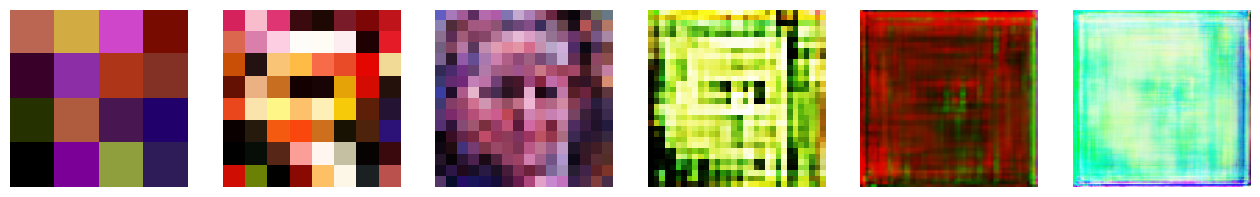

In [ ]:
import matplotlib.pyplot as plt

imgs = []
noise = torch.randn(1, config.Z_DIM, 1, 1).to(config.DEVICE)
gen.eval()
for img_size in [4, 8, 16, 32, 64, 128]:
    with torch.no_grad():
        fake = gen(noise, 1, int(log2(img_size / 4))).squeeze() * 0.5 + 0.5
        imgs.append(fake.cpu().detach().permute(1, 2, 0))

plt.figure(figsize=(16, 9))
for i in range(len(imgs)):
    plt.subplot(3, 6, i + 1)
    plt.imshow(imgs[i])
    plt.axis("off")